In [ ]:
#This is an example that uses the websockets api to know when a prompt execution is done
#Once the prompt execution is done it downloads the images using the /history endpoint

import websocket #NOTE: websocket-client (https://github.com/websocket-client/websocket-client)
import uuid
import json
import urllib.request
import urllib.parse

server_address = "127.0.0.1:8188"
client_id = str(uuid.uuid4())

def queue_prompt(prompt):
    p = {"prompt": prompt, "client_id": client_id}
    data = json.dumps(p).encode('utf-8')
    req =  urllib.request.Request("http://{}/prompt".format(server_address), data=data)
    return json.loads(urllib.request.urlopen(req).read())

def get_image(filename, subfolder, folder_type):
    data = {"filename": filename, "subfolder": subfolder, "type": folder_type}
    url_values = urllib.parse.urlencode(data)
    with urllib.request.urlopen("http://{}/view?{}".format(server_address, url_values)) as response:
        return response.read()

def get_history(prompt_id):
    with urllib.request.urlopen("http://{}/history/{}".format(server_address, prompt_id)) as response:
        return json.loads(response.read())

def get_images(ws, prompt):
    prompt_id = queue_prompt(prompt)['prompt_id']
    output_images = {}
    while True:
        out = ws.recv()
        if isinstance(out, str):
            message = json.loads(out)
            if message['type'] == 'executing':
                data = message['data']
                if data['node'] is None and data['prompt_id'] == prompt_id:
                    break #Execution is done
        else:
            # If you want to be able to decode the binary stream for latent previews, here is how you can do it:
            # bytesIO = BytesIO(out[8:])
            # preview_image = Image.open(bytesIO) # This is your preview in PIL image format, store it in a global
            continue #previews are binary data

    history = get_history(prompt_id)[prompt_id]
    for node_id in history['outputs']:
        node_output = history['outputs'][node_id]
        images_output = []
        if 'images' in node_output:
            for image in node_output['images']:
                image_data = get_image(image['filename'], image['subfolder'], image['type'])
                images_output.append(image_data)
        output_images[node_id] = images_output

    return output_images

def comfyui_generate_image(positive_prompt:str, negative_prompt:str="", width:int=512, height:int=512, batch_size:int=1, seed:int=5, steps:int=20) -> list[Image]:
    """Generate an image using the Comfy UI API.
    This function takes a positive prompt, negative prompt, width, height, batch size, seed, and steps as input parameters.
    It returns a list of images generated by the Comfy UI API.
    Args:
        positive_prompt (str): The positive prompt for the image generation.
        negative_prompt (str, optional): The negative prompt for the image generation. Defaults to "". Defaults to "".
        width (int, optional): The width of the generated image. Defaults to 512. Defaults to 512.
        height (int, optional): The height of the generated image. Defaults to 512. Defaults to 512.
        batch_size (int, optional): The batch size for the image generation. Defaults to 1. Defaults to 1. Defaults to 1.
        seed (int, optional): The seed for the image generation. Defaults to 5. Defaults to 5. Defaults to 5.
        steps (int, optional): The number of steps for the image generation. Defaults to 20. Defaults to 20.
    Returns:
        list: A list of images generated by the Comfy UI API.
    """
    prompt_json = {
        "6": {
            "inputs": {
            "text": positive_prompt,
            "clip": ["30", 1 ]
            },
            "class_type": "CLIPTextEncode",
            "_meta": {
            "title": "CLIP Text Encode (Positive Prompt)"
            }
        },
        "8": {
            "inputs": {
            "samples": [
                "31",
                0
            ],
            "vae": [
                "30",
                2
            ]
            },
            "class_type": "VAEDecode",
            "_meta": {
            "title": "VAE Decode"
            }
        },
        "9": {
            "inputs": {
            "filename_prefix": "ComfyUI",
            "images": [
                "8",
                0
            ]
            },
            "class_type": "SaveImage",
            "_meta": {
            "title": "Save Image"
            }
        },
        "27": {
            "inputs": {
            "width": width,
            "height": height,
            "batch_size": batch_size
            },
            "class_type": "EmptySD3LatentImage",
            "_meta": {
            "title": "EmptySD3LatentImage"
            }
        },
        "30": {
            "inputs": {
            "ckpt_name": "flux1-dev-fp8.safetensors"
            },
            "class_type": "CheckpointLoaderSimple",
            "_meta": {
            "title": "Load Checkpoint"
            }
        },
        "31": {
            "inputs": {
            "seed": seed,
            "steps": steps,
            "cfg": 1,
            "sampler_name": "euler",
            "scheduler": "simple",
            "denoise": 1,
            "model": [
                "30",
                0
            ],
            "positive": [
                "35",
                0
            ],
            "negative": [
                "33",
                0
            ],
            "latent_image": [
                "27",
                0
            ]
            },
            "class_type": "KSampler",
            "_meta": {
            "title": "KSampler"
            }
        },
        "33": {
            "inputs": {
            "text": negative_prompt,
            "clip": [
                "30",
                1
            ]
            },
            "class_type": "CLIPTextEncode",
            "_meta": {
            "title": "CLIP Text Encode (Negative Prompt)"
            }
        },
        "35": {
            "inputs": {
            "guidance": 3.5,
            "conditioning": [
                "6",
                0
            ]
            },
            "class_type": "FluxGuidance",
            "_meta": {
            "title": "FluxGuidance"
            }
        }
    }

    ws = websocket.WebSocket()
    ws.connect("ws://{}/ws?clientId={}".format(server_address, client_id))
    raw_images = get_images(ws, prompt_json)
    ws.close() # for in case this example is used in an environment where it will be repeatedly called, like in a Gradio app. otherwise, you'll randomly receive connection timeouts
    #Commented out code to display the output images:
    images=[]
    for node_id in raw_images:
        
        for image_data in raw_images[node_id]:
            from PIL import Image
            import io
            image = Image.open(io.BytesIO(image_data))
            images.append(image)
            
    return images



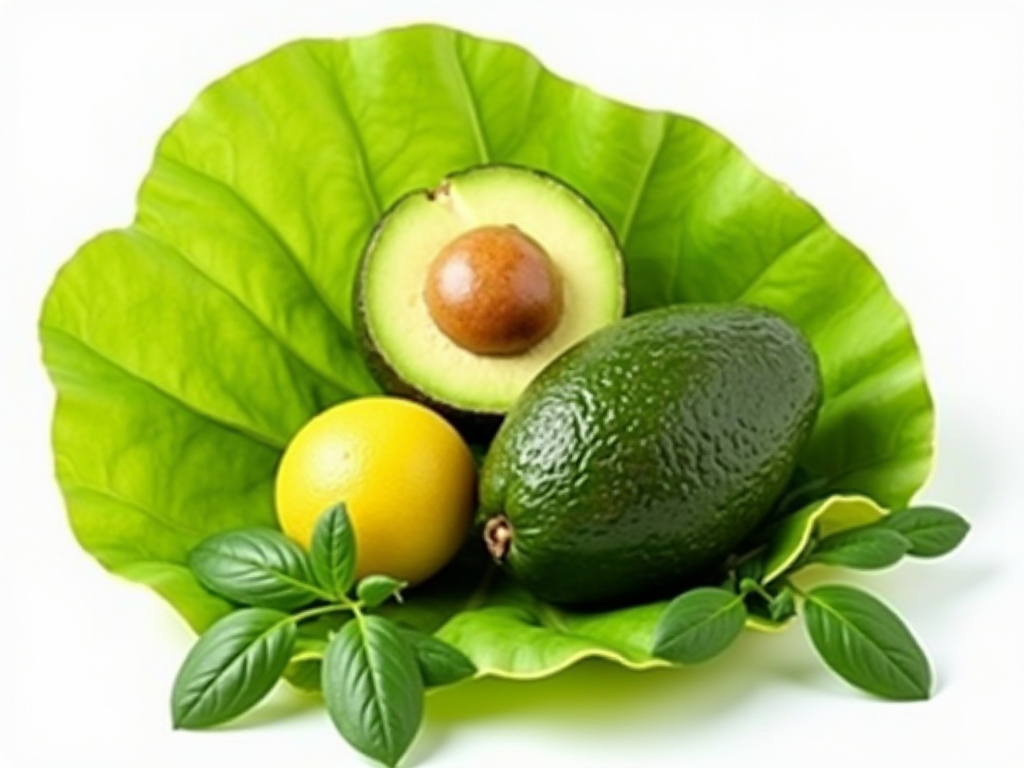

In [9]:
prompt = "an eye-catching and vibrant image of a perfectly ripe avocado. The avocado should be shown in its prime, with a rich green skin that has a slight sheen. Include subtle details like small blemishes or spots to indicate natural ripeness. The background could be a lush green leaf or a simple white surface. Add some fresh herbs or fruits around the avocado to create a cohesive and appetizing scene."

images=comfyui_generate_image(prompt, width=1024, height=768)
for image in images: 
    display(image)